# Detecting malaria with deep learning

## Project Overview

Malaria is a deadly, infectious, mosquito-borne disease caused by Plasmodium parasites that are transmitted by the bites of infected female Anopheles mosquitoes. If an infected mosquito bites you, parasites carried by the mosquito enter your blood and start destroying oxygen-carrying red blood cells (RBC). Typically, the first symptoms of malaria are similar to a virus like the flu and they usually begin within a few days or weeks after the mosquito bite. However, these deadly parasites can live in your body for over a year without causing symptoms, and a delay in treatment can lead to complications and even death. Therefore, early detection can save lives. The World Health Organization's (WHO) malaria facts indicate that nearly half the world's population is at risk from malaria, and there are over 200 million malaria cases and approximately 400,000 deaths due to malaria every year. This is a motivatation to make malaria detection and diagnosis fast, easy, and effective.

### Detection

According to WHO protocol, diagnosis typically involves intensive examination of the blood smear at 100X magnification. Trained people manually count how many red blood cells contain parasites out of 5,000 cells. As the Rajaraman, et al., paper cited above explains : 

*Thick blood smears assist in detecting the presence of parasites while thin blood smears assist in identifying the species of the parasite causing the infection (Centers for Disease Control and Prevention, 2012). The diagnostic accuracy heavily depends on human expertise and can be adversely impacted by the inter-observer variability and the liability imposed by large-scale diagnoses in disease-endemic/resource-constrained regions (Mitiku, Mengistu, and Gelaw, 2003). Alternative techniques such as polymerase chain reaction (PCR) and rapid diagnostic tests (RDT) are used; however, PCR analysis is limited in its performance (Hommelsheim, et al., 2014) and RDTs are less cost-effective in disease-endemic regions (Hawkes, Katsuva, and Masumbuko, 2009).*

Thus, malaria detection could benefit from automation using deep learning.

### Deep learning for malaria detection

Deep learning models, or more specifically convolutional neural networks (CNNs), have proven very effective in a wide variety of computer vision tasks. Convolution layers learn spatial hierarchical patterns from data, which are also translation-invariant, so they are able to learn different aspects of images. This allows CNNs to automate feature engineering and learn effective features that generalize well on new data points. Pooling layers helps with downsampling and dimension reduction. Our focus is to try some simple CNN models from scratch and a couple of pre-trained models using transfer learning.

## Problem Statement

This is an image classification problem. Inputs is balance set of parasitized and uninfected image cells and the goal is to predict if cell is infected or uninfected of malaria.

### Solution Strategy

I will be tackling problem by using Convolution neural network. I will build three deep learning models, train them with training dataset. Each model will be saved and evaluated. Model 1 will be basic CNN model. Model 2 will be pre-trained model as a feature extractor and Model 3 will be Fine-tuned pre-trained model with image augmentation. 

### Metrics

Performance of a model will be evaluted using F1 score. Model need to have high recall value as false-negative can not be tolerated for the requirement of malaria detection. False negative result can risk the life of patient. So even though accuracy and precision will also be calculated with recall and F1 score, Recall is the evalution metric which will be key point of consideration. Minimum of 80% accuracy, precision, recall and F1 score is desired for the best model.

## Data Exploration and Preprocessing

The data for our analysis comes from researchers at the Lister Hill National Center for Biomedical Communications (LHNCBC), part of the National Library of Medicine (NLM), who have carefully collected and annotated the publicly available dataset of healthy and infected blood smear images. Let's briefly decribe the dataset's structure. We have two folders that contain images of cells, infected and healthy. We can get further details about the total number of images by entering:

In [1]:
import os
import glob

base_dir = os.path.join('./cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./cell_images/Parasitized/C48P9thinF_IMG_20150...,malaria
1,./cell_images/Parasitized/C97P58ThinF_IMG_2015...,malaria
2,./cell_images/Uninfected/C80P41ThinF_IMG_20150...,healthy
3,./cell_images/Uninfected/C130P91ThinF_IMG_2015...,healthy
4,./cell_images/Uninfected/C71P32_ThinF_IMG_2015...,healthy


It looks like we have a balanced dataset with 13,779 malaria and 13,779 non-malaria (uninfected) cell images. Let's build a data frame from this, which we will use when we start building our datasets.

In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))


(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


### Build and explore image datasets

To build deep learning models, we need training data, but we also need to test the model's performance on unseen data. We will use a 60:10:30 split for train, validation, and test datasets, respectively. We will leverage the train and validation datasets during training and check the performance of the model on the test dataset.

In [4]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_19: working on img num: 5000
ThreadPoolExecutor-0_3: working on img num: 10000
ThreadPoolExecutor-0_12: working on img num: 15000
ThreadPoolExecutor-0_9: working on img num: 17360
Min Dimensions: [46 49  3]
Avg Dimensions: [ 133.08553655  132.55676516    3.        ]
Median Dimensions: [ 130.  130.    3.]
Max Dimensions: [385 394   3]


The images will not be of equal dimensions because blood smears and cell images vary based on the human, the test method, and the orientation of the photo. Let's get some summary statistics of our training dataset to determine the optimal image dimensions. We apply parallel processing to speed up the image-read operations and, based on the summary statistics, we will resize each image to 125x125 pixels. Let's load up all of our images and resize them to these fixed dimensions.

In [5]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  


Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_6: working on img num: 5000
ThreadPoolExecutor-1_13: working on img num: 10000
ThreadPoolExecutor-1_4: working on img num: 15000
ThreadPoolExecutor-1_12: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_14: working on img num: 0
ThreadPoolExecutor-1_4: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_8: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 5000
ThreadPoolExecutor-1_18: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

## Exploratory Visualization

We leverage parallel processing again to speed up computations pertaining to image load and resizing. Finally, we get our image tensors of the desired dimensions, as depicted in the preceding output. We can now view some sample cell images to get an idea of how our data looks.

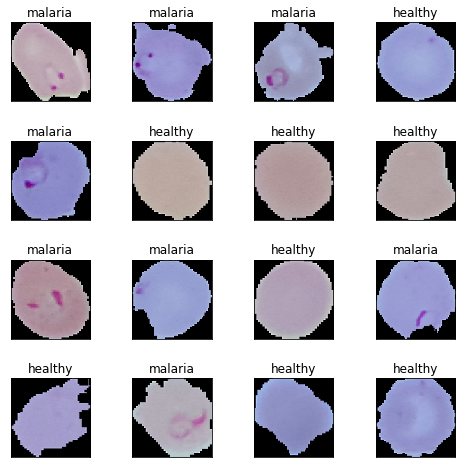

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

## Benchmark

Based on these sample images, we can see some subtle differences between malaria and healthy cell images. We will make our deep learning models try to learn these patterns during model training.

In [7]:
INPUT_SHAPE = (125, 125, 3)
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


We fix our image dimensions, batch size, and epochs and encode our categorical class labels.

## Deep learning model training

### Model 1: CNN from scratch

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model_basic = Sequential()

model_basic.add(Conv2D(filters = 32,padding = 'same',activation = 'relu',kernel_size = 3, input_shape = INPUT_SHAPE))

model_basic.add(MaxPooling2D(pool_size = 2))

model_basic.add(Conv2D(filters = 64,padding = 'same',activation = 'relu',kernel_size = 3))

model_basic.add(MaxPooling2D(pool_size = 2))

model_basic.add(Conv2D(filters = 128,padding = 'same',activation = 'relu',kernel_size = 3))

model_basic.add(MaxPooling2D(pool_size = 2))

model_basic.add(Flatten())

model_basic.add(Dense(512, activation = 'relu'))

model_basic.add(Dropout(rate = 0.3))

model_basic.add(Dense(512, activation = 'relu'))

model_basic.add(Dropout(rate = 0.3))

model_basic.add(Dense(1, activation = 'sigmoid'))


#compiling the model_basic
model_basic.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model_basic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
__________

CNN model has three convolution and pooling layers, followed by two dense layers, and dropouts for regularization. Training the model :

In [12]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'CNN.Malaria.ImageProcessing.Weights.basic.T1', verbose = 1, save_best_only = True)

history_basic = model_basic.fit(x=train_imgs_scaled, y=train_labels_enc,verbose = 1, shuffle = True,
                 batch_size=BATCH_SIZE,epochs=EPOCHS, 
                 validation_data=(val_imgs_scaled, val_labels_enc), 
                 callbacks = [checkpointer])

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 41s 2ms/step - loss: 0.4689 - acc: 0.7490 - val_loss: 0.1804 - val_acc: 0.9419
Epoch 2/25
17361/17361 [==============================] - 37s 2ms/step - loss: 0.1544 - acc: 0.9497 - val_loss: 0.1413 - val_acc: 0.9575
Epoch 3/25
17361/17361 [==============================] - 36s 2ms/step - loss: 0.1301 - acc: 0.9588 - val_loss: 0.1532 - val_acc: 0.9580
Epoch 4/25
17361/17361 [==============================] - 37s 2ms/step - loss: 0.1086 - acc: 0.9646 - val_loss: 0.1538 - val_acc: 0.9590
Epoch 5/25
17361/17361 [==============================] - 36s 2ms/step - loss: 0.0918 - acc: 0.9696 - val_loss: 0.1502 - val_acc: 0.9590
Epoch 6/25
17361/17361 [==============================] - 37s 2ms/step - loss: 0.0744 - acc: 0.9750 - val_loss: 0.1734 - val_acc: 0.9554
Epoch 7/25
17361/17361 [==============================] - 36s 2ms/step - loss: 0.0557 - acc: 0.9813 - val_loss: 0.1879 - val_acc:

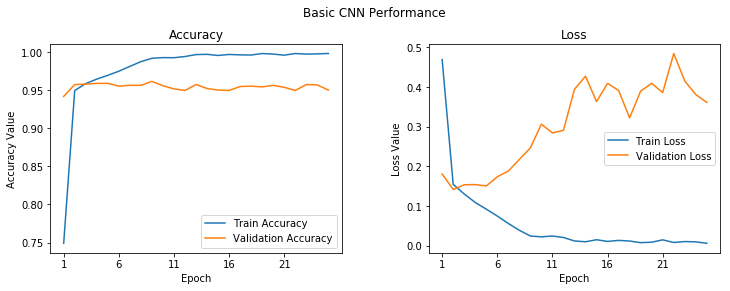

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history_basic.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history_basic.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_basic.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_basic.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_basic.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [37]:
accuracy_basic = np.max(history_basic.history['acc'])*100
validation_accuracy_basic = np.max(history_basic.history['val_acc'])*100

print("Accuracy of basic CNN model : %.2f"%accuracy_basic+"%")
print("Validation accuracy of basic CNN model : %.2f"%validation_accuracy_basic+"%")

Accuracy of basic CNN model : 99.83%
Validation accuracy of basic CNN model : 96.16%


Model is slightly overfitting. Training accuracy and Validation accuracy are plotted below with a loss curve.

In [38]:
model_basic.save('basic_cnn.h5')

### Model 2: Pre-trained model as a feature extractor

We will be using the pre-trained VGG-19 deep learning model, developed by the Visual Geometry Group (VGG) at the University of Oxford, for our experiments. A pre-trained model like VGG-19 is trained on a huge dataset (ImageNet) with a lot of diverse image categories. Therefore, the model should have learned a robust hierarchy of features, which are spatial-, rotational-, and translation-invariant with regard to features learned by CNN models.

#### Understanding the VGG-19 model

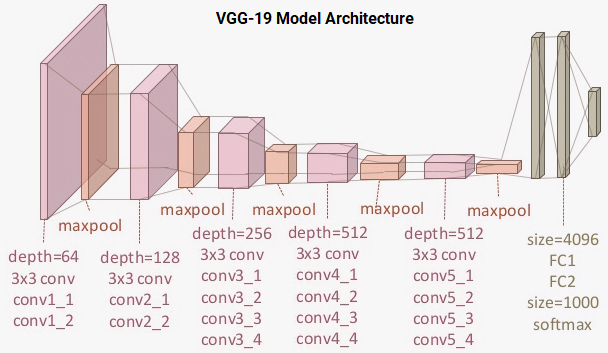

The VGG-19 model is a 19-layer (convolution and fully connected) deep learning network built on the ImageNet database, which was developed for the purpose of image recognition and classification. The model have a total of 16 convolution layers using 3x3 convolution filters along with max pooling layers for downsampling and two fully connected hidden layers of 4,096 units in each layer followed by a dense layer of 1,000 units, where each unit represents one of the image categories in the ImageNet database. We do not need the last three layers since we will be using our own fully connected dense layers to predict malaria. We are more concerned with the first five blocks so we can leverage the VGG model as an effective feature extractor. We will use one of the models as a simple feature extractor by freezing the five convolution blocks to make sure their weights aren't updated after each epoch.

In [39]:
from keras.applications.vgg19 import VGG19
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import Model

vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = Flatten()(base_out)
hidden1 = Dense(512, activation='relu')(pool_out)
drop1 = Dropout(rate=0.3)(hidden1)
hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.3)(hidden2)

out = Dense(1, activation='sigmoid')(drop2)

model_pre_trained = Model(inputs=base_vgg.input, outputs=out)

model_pre_trained.compile(optimizer = 'RMSprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model_pre_trained.summary()

80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 125, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool

In [42]:
print("Total Layers:", len(model_pre_trained.layers))
print("Total trainable layers:", 
      sum([1 for l in model_pre_trained.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [41]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'CNN.Malaria.ImageProcessing.Weights.VGG19.PreTrained.T2',
                               verbose = 1, save_best_only = True)

history_pre_trained = model_pre_trained.fit(x=train_imgs_scaled, y=train_labels_enc,verbose = 1, shuffle = True,
                         batch_size=BATCH_SIZE,epochs=EPOCHS, 
                         validation_data=(val_imgs_scaled, val_labels_enc), 
                         callbacks = [checkpointer])

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 151s 9ms/step - loss: 7.9665 - acc: 0.4971 - val_loss: 8.0166 - val_acc: 0.4971
Epoch 2/25
17361/17361 [==============================] - 147s 8ms/step - loss: 8.0203 - acc: 0.4969 - val_loss: 8.0166 - val_acc: 0.4971
Epoch 3/25
17361/17361 [==============================] - 147s 8ms/step - loss: 7.0097 - acc: 0.5159 - val_loss: 0.6989 - val_acc: 0.5360
Epoch 4/25
17361/17361 [==============================] - 147s 8ms/step - loss: 0.4035 - acc: 0.8171 - val_loss: 0.2723 - val_acc: 0.8963
Epoch 5/25
17361/17361 [==============================] - 147s 8ms/step - loss: 0.3070 - acc: 0.8742 - val_loss: 0.2962 - val_acc: 0.8678
Epoch 6/25
17361/17361 [==============================] - 147s 8ms/step - loss: 0.2757 - acc: 0.8904 - val_loss: 0.3701 - val_acc: 0.8466
Epoch 7/25
17361/17361 [==============================] - 147s 8ms/step - loss: 0.2555 - acc: 0.8985 - val_loss: 0.5005 - v

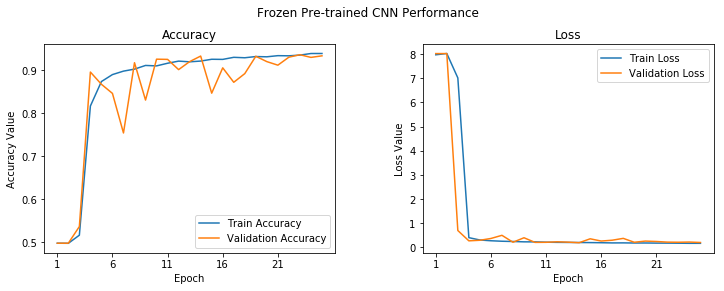

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Frozen Pre-trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history_pre_trained.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history_pre_trained.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_pre_trained.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_pre_trained.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_pre_trained.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [44]:
accuracy_pre_trained = np.max(history_pre_trained.history['acc'])*100
validation_accuracy_pre_trained = np.max(history_pre_trained.history['val_acc'])*100

print("Accuracy of pre_trained CNN model : %.2f"%accuracy_pre_trained+"%")
print("Validation accuracy of pre_trained CNN model : %.2f"%validation_accuracy_pre_trained+"%")

Accuracy of pre_trained CNN model : 93.96%
Validation accuracy of pre_trained CNN model : 93.68%


This shows that our model is not overfitting as much as our basic CNN model, but the performance is slightly less than our basic CNN model.

In [46]:
model_pre_trained.save('vgg_frozen.h5')

### Model 3: Fine-tuned pre-trained model with image augmentation

In our final model, we will fine-tune the weights of the layers in the last two blocks of our pre-trained VGG-19 model. We will also introduce the concept of image augmentation. The idea behind image augmentation is exactly as the name sounds. We load in existing images from our training dataset and apply some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images. Due to these random transformations, we don't get the same images each time. We will leverage an excellent utility called ImageDataGenerator in keras that can help build image augmentors.

#### Build Image Augmentors

In [47]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.05, rotation_range=25,
                                   width_shift_range=0.05, height_shift_range=0.05, 
                                   shear_range=0.05, horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

We will not apply any transformations on our validation dataset (except for scaling the images, which is mandatory) since we will be using it to evaluate our model performance per epoch. 

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


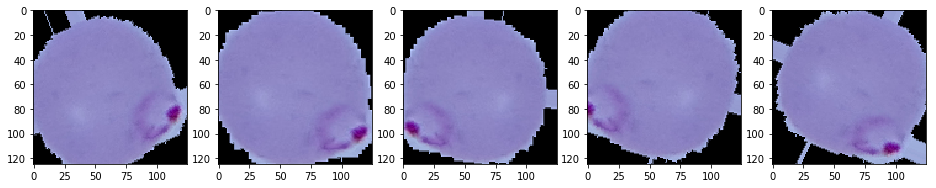

In [48]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [49]:
# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

You can clearly see the slight variations of our images in the preceding output. We will now build our deep learning model, making sure the last two blocks of the VGG-19 model are trainable.

In [50]:
from keras import optimizers

vgg = VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)

# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
        
base_vgg = vgg
base_out = base_vgg.output
pool_out = Flatten()(base_out)
hidden1 = Dense(512, activation='relu')(pool_out)
drop1 = Dropout(rate=0.3)(hidden1)
hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.3)(hidden2)

out = Dense(1, activation='sigmoid')(drop2)

model_fine_tuned = Model(inputs=base_vgg.input, outputs=out)

RMSprop = optimizers.RMSprop(lr=1e-5)

model_fine_tuned.compile(optimizer = RMSprop,
                loss='binary_crossentropy',
                metrics=['accuracy'])
model_fine_tuned.summary()
print("Total Layers:", len(model_fine_tuned.layers))
print("Total trainable layers:", sum([1 for l in model_fine_tuned.layers if l.trainable]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 125, 125, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0         
__________

In [51]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'CNN.Malaria.ImageProcessing.Weights.VGG19.FineTuned.T3', verbose = 1, save_best_only = True)

train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size

history_fine_tuned = model_fine_tuned.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1,callbacks = [checkpointer])

Epoch 1/25
271/271 [==============================] - 254s 936ms/step - loss: 0.2295 - acc: 0.9092 - val_loss: 0.1338 - val_acc: 0.9552
Epoch 2/25
271/271 [==============================] - 251s 925ms/step - loss: 0.1381 - acc: 0.9553 - val_loss: 0.1399 - val_acc: 0.9536
Epoch 3/25
271/271 [==============================] - 251s 926ms/step - loss: 0.1224 - acc: 0.9588 - val_loss: 0.1261 - val_acc: 0.9594
Epoch 4/25
271/271 [==============================] - 251s 926ms/step - loss: 0.1170 - acc: 0.9610 - val_loss: 0.1287 - val_acc: 0.9594
Epoch 5/25
271/271 [==============================] - 251s 925ms/step - loss: 0.1106 - acc: 0.9626 - val_loss: 0.1289 - val_acc: 0.9583
Epoch 6/25
271/271 [==============================] - 251s 926ms/step - loss: 0.1061 - acc: 0.9638 - val_loss: 0.1095 - val_acc: 0.9635
Epoch 7/25
271/271 [==============================] - 251s 925ms/step - loss: 0.1016 - acc: 0.9658 - val_loss: 0.1216 - val_acc: 0.9641
Epoch 8/25
271/271 [============================

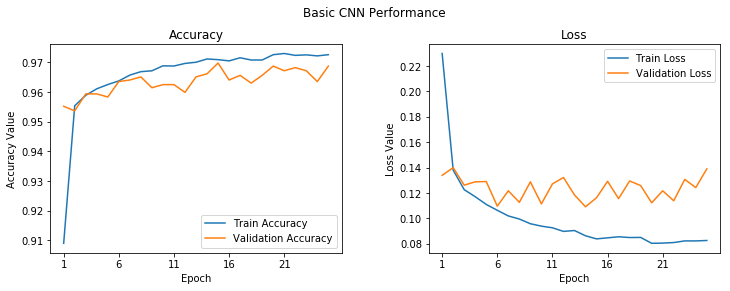

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history_fine_tuned.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history_fine_tuned.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_fine_tuned.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_fine_tuned.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_fine_tuned.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [54]:
accuracy_fine_tuned = np.max(history_fine_tuned.history['acc'])*100
validation_accuracy_fine_tuned = np.max(history_fine_tuned.history['val_acc'])*100

print("Accuracy of fine_tuned CNN model : %.2f"%accuracy_fine_tuned+"%")
print("Validation accuracy of fine_tuned CNN model : %.2f"%validation_accuracy_fine_tuned+"%")

Accuracy of fine_tuned CNN model : 97.30%
Validation accuracy of fine_tuned CNN model : 96.98%


This looks to be best model yet. It gives us a validation accuracy of almost 96.5% and, based on the training accuracy, it doesn't look like our model is overfitting as much as our first model. This can be verified with the following learning curves.

In [55]:
model_fine_tuned.save('vgg_finetuned.h5')

## Model Performance Evaluation

We will evaluate the three models we built in the training phase by making predictions with them on the data from our test dataset. model_evaluation_utils module is created to evaluate the performance of the deep learning models with classification metrics. Steps followed for evaluation are :-

-  Scale test data
-  Load saved deep learning models
-  Make prediction on test data
-  Leverage model_evaluation_utils to check the performance of models

In [8]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [9]:
! ls -l --block-size=MB | grep .h5

-rw-r--r-- 1 root root 182MB Jun 19 20:29 basic_cnn.h5
-rw-r--r-- 1 root root 172MB Jun 19 23:16 vgg_finetuned.h5
-rw-r--r-- 1 root root 102MB Jun 19 21:31 vgg_frozen.h5


In [10]:
from keras import models

basic_cnn = models.load_model('./basic_cnn.h5')
vgg_frz = models.load_model('./vgg_frozen.h5')
vgg_ft = models.load_model('./vgg_finetuned.h5')

Using TensorFlow backend.


In [11]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [12]:
import model_evaluation_utils as meu
import pandas as pd

basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics], 
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])

,Accuracy,F1 Score:,Precision:,Recall
Basic CNN,0.9507,0.9507,0.9507,0.9507
VGG-19 Frozen,0.9347,0.9347,0.9349,0.9347
VGG-19 Fine-tuned,0.9653,0.9653,0.9654,0.9653


In [13]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=basic_cnn_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------

Model Classification report:
------------------------------
             precision    recall  f1-score   support

    healthy       0.95      0.95      0.95      4075
    malaria       0.95      0.95      0.95      4193

avg / total       0.95      0.95      0.95      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3867     208
        malaria        200    3993


In [14]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_frz_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------

Model Classification report:
------------------------------
             precision    recall  f1-score   support

    healthy       0.92      0.94      0.93      4075
    malaria       0.94      0.93      0.93      4193

avg / total       0.93      0.93      0.93      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3849     226
        malaria        314    3879


In [15]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_ft_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------

Model Classification report:
------------------------------
             precision    recall  f1-score   support

    healthy       0.96      0.97      0.97      4075
    malaria       0.97      0.96      0.97      4193

avg / total       0.97      0.97      0.97      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3968     107
        malaria        180    4013


As we can observe third model performs best on the test dataset, giving a model recall and an F1-score of 96%, which is pretty good. It is far beyond the expected 80% benchmark criteria of Recall and F1-score.

## Conclusion

Deep learning CNN models has provided excellent solution to Malaria detection problem. The result are extremely encouraging for the implementation of AI in field of medical science. Such models can be easily implemented in practical use with Android and iOS apps to provide quick and cheap detection of malaria and reduce manual effort and cost of the process in countries where people can not affort proper health care facilities and lack qualified professionals. As there is always room for improvement depicted in above 3 models where we achieved improving result with each attempt, we can state that better and deeper model can be created to obtain even better results.